
Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [0]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [3]:
transform = transforms.Compose( #Here, we are chaining different image transformations together using Compose
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

'''
*When normalizing, the following procedure is perfomed for each of the channels: (image = (image - mean) / std).
where the parameters mean and std are both set to 0.5, normalizing the image between [-1,1].

*'ToTensor' allows us to convert PIL Images, or a numpy.ndarray (H x W x C) in the range [0, 255], to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
'A PyTorch Tensor is conceptually identical to a numpy array: a Tensor is an n-dimensional array, and PyTorch provides many functions for operating on these Tensors. 
Behind the scenes, Tensors can keep track of a computational graph and gradients, but they’re also useful as a generic tool for scientific computing'.
'''


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

'''
*Loading Datasets: pytorch allow us to directly load CIFAR10 dataset since it is treated as a subclass of torch.utils.data.Dataset. Moreover, the CIFAR10 dataset was passed
to a torch.utils.data.DataLoader which can load multiple samples in parallell using torch.multiprocessing workers (2).

*DataLoader supports automatically collating individual fetched data samples into batches via arguments batch_size, drop_last, and batch_sampler. 
For this CNN_I, the number of samples per batch was set to 64. batch_size and drop_last arguments are used to specify how the data loader obtains batches of dataset keys.
For map-style datasets, batch_sampler will yield a list of keys at a time.

*Setting the argument num_workers as a positive integer (2 in this case) turns on multi-process data loading with the specified number of loader worker processes.
In this mode, each time an iterator of a DataLoader is created, num_workers worker processes are created. 

'''

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


'\n*Loading Datasets: pytorch allow us to directly load CIFAR10 dataset since it is treated as a subclass of torch.utils.data.Dataset. Moreover, the CIFAR10 dataset was passed\nto a torch.utils.data.DataLoader which can load multiple samples in parallell using torch.multiprocessing workers (2).\n\n*DataLoader supports automatically collating individual fetched data samples into batches via arguments batch_size, drop_last, and batch_sampler. \nFor this CNN_I, the number of samples per batch was set to 64. batch_size and drop_last arguments are used to specify how the data loader obtains batches of dataset keys.\nFor map-style datasets, batch_sampler will yield a list of keys at a time.\n\n*Setting the argument num_workers as a positive integer (2 in this case) turns on multi-process data loading with the specified number of loader worker processes.\nIn this mode, each time an iterator of a DataLoader is created, num_workers worker processes are created. \n\n'

Let us show some of the training images, for fun.



 deer truck truck plane


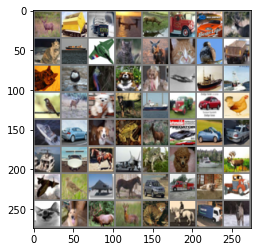

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image... since we increased batch_size to 64 (tutorial 
# originally had 4) this isn't as informative and we omit printing out 64 class labels

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^




In [0]:
import torch.nn as nn
import torch.nn.functional as F

#Here we define our neural net architecture 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() #lets us avoid referring to the base class explicitly and enables multiple inheritance

        #Now we define the convolution, pooling, and linear layers
        
        #nn.Conv2d applies a 2D convolution over an input signal composed of several input planes. Two convolutional layers are computed here.

        self.conv1 = nn.Conv2d(3, 6, 5) # Convolutional layer 1: 3 input channels (RGB images), 6 output channels (6 filters) and 5 filter size (kernel size)
        '''Here we have 3 input channels that will be convolved by 6 different filters which will create 6 different output channels. It is also important to point out that the values
        choosen as out channels are related to the nodes that we are expecting to have in our layer.
        
        We keep the remaining parameters as their default values. For instance, stride has a value equal to 1 meaning that regular 1 by 1 steps (units) are being considered for moving (right and down)
        the filter within the input signal. No padding is considered since the default value is equal to 0. Dilation value is 1 (this parameter controls the spacing between
        the kernel points), groups is equal to 1 (this parameter controls the connections between inputs and outputs) and finally bias is equal to True meaning that is adding a 
        learnable bias to the output. 
        '''
        self.pool = nn.MaxPool2d(2, 2)   # Pooling layer (same one used as both pooling layers): 2 filter size and with a stride of 2
        
        '''Here pooling is included. More specifically, maxpooling over an input signal composed of several input planes, 
        where the signal is divided in zones and the max value from each zone is taken. The two values between parentheses correspond to a kernel size equal
        to 2 and a stride (steps within the input signal) equal to 2. '''

        self.conv2 = nn.Conv2d(6, 16, 5) # CONVULUTIONAL LAYER 2 with 6 in channels ,16 out channels and 5 filter size (kernel size)
        '''Here we have 6 input channels (the output of the previous layer) that will be convolve by 16 different filters which will create 16 diff output channels 
        
        The remaining parameters conserve their default values. For instance, stride has a value equal to 1 meaning that regular 1 by 1  steps (units) are being considered for moving (right and down)
        the filter within the input signal. No padding is considered since the default value is equal to 0. Dilation value is 1 ( this parameter controls the spacing between
        the kernel points), groups is equal to 1 (this parameter controls the connections between inputs and outputs) and finally bias is equal to True meaning that is adding a 
        learnable bias to the output
        
        '''
        #Here, we are creating 3 linear layers with Linear, we are basically applying a linear transformation to the incoming data, such that: y = xA^T + by
        # for each fc1, fc2 and fc3, 3 arguments used are the size of each input sample, size of each output sample and the bias. In fc2 and fc3, the default value True is used for the bias.
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 5*5 are height and width of each of the 10 output channels
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) #note that the output features for the final linear layer was choosen as 10 since we are dealing with 10 classes

        '''it is important to mention that we specify our layers as class atributtes inside our network class. Pytorch (as a module class) keep track of the weight tensor
        inside each layer which is basically what is changing or 'learning'''
        
        #Pytorch allows us to perform the computation graphs that keep track of the network mapping by tracking each computation that happens as the tensor propagates forward to the network.
        #this will be used also in the training process to calculate the derivative (gradient) of the loss function
    def forward(self, x):
        #(1) hidden layer
        x = self.pool(F.relu(self.conv1(x))) #first the convolutional operations is applied for the input signal and is followed by a ReLu activation.

        #(2) hidden layer
        x = self.pool(F.relu(self.conv2(x))) #the output of the 1st convolutional layer is taken as an input for this second layer. 
        #Note that we are also reducing the size of the representation by pooling in each of the convolutional layers

        x = x.view(-1, 16 * 5 * 5) #here we are re-shaping since we are coming from a conflate as input to a linear layer
        #the tensor arrives to the first linear layer with a reduced size of 4x4 due to the convolution and the pooling operations.

        #(3) hidden layer
        x = F.relu(self.fc1(x))#ReLu activation function is applied for the linear layer.

        #(4) hidden layer
        x = F.relu(self.fc2(x))#ReLu activation function is applied for the linear layer.

        #(5) hidden layer
        x = self.fc3(x)  #final linear output layer
        return x


net = Net() #creating an instance of our network class

In [6]:
print(net) #see the network architecture


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [0]:
import torch.optim as optim 

criterion = nn.CrossEntropyLoss() #The cross_entropy loss function applies a log softmax on the outputs to compared and give the loss.
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9) #SGD optimizer with lr=0.01 and momentum=0.9. Momentum helps accelerate the gradient vectors in the right directions to obtain faster converging

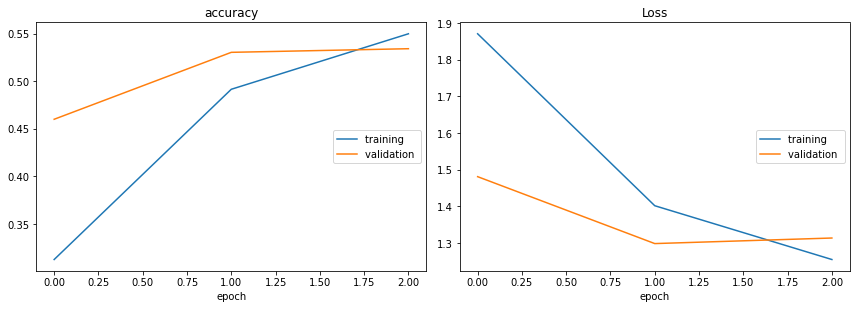

accuracy
	training         	 (min:    0.313, max:    0.550, cur:    0.550)
	validation       	 (min:    0.460, max:    0.534, cur:    0.534)
Loss
	training         	 (min:    1.255, max:    1.870, cur:    1.255)
	validation       	 (min:    1.299, max:    1.481, cur:    1.314)


KeyboardInterrupt: ignored

In [8]:

#Here we implement livelossplot which will plot our training and testing (livelossplot thinks it's validation but we are giving it the test set). 
!pip install livelossplot --quiet
from livelossplot import PlotLosses

''''For training, we have first to get a batch from the training set in order to pass that batch to the network, then calculate the loss and the gradient of the loss in order
to update the weights using the gradients to reduce the loss. That process is performed for one epoch'''

dataloaders = {
    "train": trainloader,
    "testing": testloader
}
#set the device to gpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def getnumcorrect (preds, labels): #get the number of correct labels
  return preds.argmax(dim=1).eq(labels).sum().item()



num_epochs=30       # run over 30 epochs
min_loss = 1        # set our minimum loss for stopping 
waiting_loss = 0    # used to calculate stopping
n_epochs_stop = 5   # if there is no improvement on the loss for 5 straight epochs we end the process
epochs_no_improve = 0  # counts how many epochs in a row it goes without loss improvment
early_stop= False     # set to false to start
correctones=[]        # initialize an array for correctones
losses=[]             # initialize an array for losses
liveloss = PlotLosses() 
net = net.to(device)
for epoch in range(num_epochs): # loop over the dataset multiple times
        logs = {}
        for phase in ['train', 'testing']:  #going through all the batches from our training set and testing set
            if phase == 'train':
                net.train()
            else:
                net.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]: #we are unpacking the 'images' inputs and labels from the current batch
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward + backward + optimize
                outputs = net(inputs) #pass the 'images' inputs to the network and what we get here is the predicted values (tensor)
                loss = criterion(outputs, labels) #we apply our cross entropy loss function over the predictions and the labels (targets)

                if phase == 'train':
                    optimizer.zero_grad() # zero the parameter gradients
                    loss.backward() #calculating the gradients by calling the backward function on the loss tensor. When we call backward() all of the gradients for all of the tensor are calculated
                    optimizer.step() #we call the optimizer (SGD). Here the weights are updated, when we call step() in our optimizer we are telling it that we want to step in the direction of the loss function minimum
                  

                #update running loss and correct count
                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # if running_loss is smaller than min_loss but bigger than the previous epoch loss, then we add to the count for epochs_no_improve
                if waiting_loss < running_loss < min_loss:
                  epochs_no_improve += 1
                # stop running if we have no improvement 5 epochs in a row
                if epochs_no_improve == n_epochs_stop:
                   print('Early stopping!' )
                   early_stop = True
                   break
                else:
                   continue

                waiting_loss = running_loss

            #if stopped early, it lets us know
            if early_stop:
              print("Stopped")
              break  
            # calculate the loss and accuracy for the epoch
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            
            #for liveloss
            prefix = ''
            if phase == 'testing':
                prefix = 'val_'

            logs[prefix + 'loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()

        #update liveloss so it plots accuracy and loss live each epoch
        liveloss.update(logs)
        liveloss.send()


Playing around by Testing the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



In [0]:
# Everything after this point is just for interest in the output and does not effect the neural net 

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images and labels
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(64)))

Okay, now let us see what the neural network thinks these examples above are:



In [0]:
outputs = net(images) #set outputs from the net

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [0]:
#print out predictions
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(64)))

The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [0]:
# Here we print out the accuracy on the whole dataset

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [0]:
# Here we print out the accuracies per class to see if any particular class
# under or over performed with respect to the average.

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))